# Price Data Extraction for Post-Index Rebalancing Arbitrage Strategy

Data source: Refinitiv Datastream via WRDS

This notebook executes codes to extract relevant data, based on the historical records of FTSE100 and FTSE250 rebalancing, for the past 10 years (2013Q1 - 2023Q3).
In this exercise, the following stocks are excluded:
- Stocks that are suspended from trading within the analysis period (+/- 20 days from rebalancing date)
- Stocks which rebalancing dates fall within the announcement date and the ex date of a corporate action
- Stocks that we are unable to obtain a reliable historical data on
- All Q3 2023 rebalancing; at time of study we are unable to obtain 20 days after the rebalancing date

In [1]:
# Import WRDS library
import wrds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

## Data Extraction

In [2]:
def read_sql_script(fname):
    fd = open(fname, 'r')
    sqlFile = fd.read()
    fd.close()

    return sqlFile


# Get current path
current_dir = os.getcwd()


# Define sql file names
# these will be used as a global variable
query_historical_prices = read_sql_script('../SQL/get_historical_prices.sql')
query_shares_outstanding = read_sql_script('../SQL/get_shares_outstanding.sql')

# Establish live connection; requires user login (passwords will be masked)
db = wrds.Connection() # this will be used as a global variable


def get_historical_prices(isin, start_date, end_date):
    
    # print(f'Extracting historical prices for {isin}...')

    df =\
    (
        db
        .raw_sql(
            query_historical_prices.format(isin, start_date, end_date), 
            date_cols = ['trade_date']
            )
    )

    if df.empty:
        print('Dataframe is empty. No results was returned!')
    
    # print('--------------------------------------------------')

    return df


WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time
with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
ftse_rebal = pd.read_csv('../constituent_history/ftse_10y_rebal_records.csv')

In [4]:
look_back = 40
look_forward = 40

ftse_rebal["Post Date"] =\
    pd.to_datetime(ftse_rebal["Post Date"], 
                   format = '%d/%m/%Y')

ftse_rebal["start_date"] =\
    (
        ftse_rebal["Post Date"] - timedelta(days = look_back)
    ).dt.strftime('%d/%m/%Y')

ftse_rebal["end_date"] =\
    (
        ftse_rebal["Post Date"] + timedelta(days = look_back)
    ).dt.strftime('%d/%m/%Y')

In [5]:
target_isins = ftse_rebal["ISIN"]
start_dates = ftse_rebal["start_date"]
end_dates = ftse_rebal["end_date"]   


historical_prices =\
    (
        pd.
        concat(
            map(
                get_historical_prices,
                target_isins,
                start_dates,
                end_dates
            )
        )
    )

Dataframe is empty. No results was returned!


In [6]:
historical_prices.head()

,trade_date,security_code,security_name,primary_exchange,refinitiv_code,isin_code,currency,open,high,low,close,volume
0,2023-08-09,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.066,1.136,1.063000,1.117,358252.0
1,2023-08-10,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.140,1.140,1.091000,1.120,284950.0
2,2023-08-11,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.331,1.098000,1.150,1003896.0
3,2023-08-14,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.147,1.160,1.088108,1.096,1088784.0
4,2023-08-15,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.126,1.001000,1.114,1127118.0


## Data Cleaning

In [7]:

index_close_data = pd.read_csv('../output/FTSE_100_Index_10y.csv', header = 0)

index_close_data["Date"] =\
    (
        index_close_data["Date"]
        .apply(lambda x: datetime.strptime(x,'%d/%m/%y'))
    )


In [8]:
index_close_data.head()

,Date,Close,Net,%Chg,Open,Low,High,Volume,Turnover - GBP,Flow
0,2012-02-01,"5,790.72",NaN,NaN,"5,681.61","5,680.67","5,790.72","985,247,019","379,738.00",0.00
1,2012-02-02,"5,796.07",5.35,+0.09%,"5,790.72","5,765.72","5,809.82","967,388,509","473,806.00","473,806.00"
2,2012-02-03,"5,901.07",105.00,+1.81%,"5,796.07","5,784.23","5,901.07","1,156,774,184","413,725.00","887,531.00"
3,2012-02-06,"5,892.20",-8.87,-0.15%,"5,901.07","5,863.55","5,901.07","828,464,520","302,457.00","585,074.00"
4,2012-02-07,"5,890.26",-1.94,-0.03%,"5,892.20","5,850.49","5,906.65","785,340,692","354,319.00","230,755.00"


In [9]:
full_ftse_data = historical_prices.copy()

## HEREEEE

In [10]:
## Use this instead
full_ftse_data =\
(
    full_ftse_data
    .merge(
        index_close_data[['Date', 'Close']],
        how = 'left',
        left_on = 'trade_date',
        right_on = 'Date'
    )
)

full_ftse_data.head()

,trade_date,security_code,security_name,primary_exchange,refinitiv_code,isin_code,currency,open,high,low,close,volume,Date,Close
0,2023-08-09,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.066,1.136,1.063000,1.117,358252.0,2023-08-09,"7,587.30"
1,2023-08-10,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.140,1.140,1.091000,1.120,284950.0,2023-08-10,"7,618.60"
2,2023-08-11,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.331,1.098000,1.150,1003896.0,2023-08-11,"7,524.16"
3,2023-08-14,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.147,1.160,1.088108,1.096,1088784.0,2023-08-14,"7,507.15"
4,2023-08-15,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.126,1.001000,1.114,1127118.0,2023-08-15,"7,389.64"


In [11]:
full_ftse_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32913 entries, 0 to 32912
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trade_date        32913 non-null  datetime64[ns]
 1   security_code     32913 non-null  float64       
 2   security_name     32913 non-null  object        
 3   primary_exchange  32913 non-null  object        
 4   refinitiv_code    32913 non-null  float64       
 5   isin_code         32913 non-null  object        
 6   currency          32913 non-null  object        
 7   open              32869 non-null  float64       
 8   high              32869 non-null  float64       
 9   low               32869 non-null  float64       
 10  close             32876 non-null  float64       
 11  volume            32816 non-null  float64       
 12  Date              32905 non-null  datetime64[ns]
 13  Close             32905 non-null  object        
dtypes: datetime64[ns](2), 

In [12]:
lse_historical_prices =\
    full_ftse_data[['trade_date', 'security_name', 'primary_exchange','isin_code', 
                    'currency', 'close', 'volume', 'Close']]\
        .loc[full_ftse_data.primary_exchange == 'LON', :]\
            .copy()

lse_historical_prices =\
    lse_historical_prices.rename(columns = {'Close':'index_close'})

lse_historical_prices['index_close'] =\
    lse_historical_prices['index_close']\
        .str\
            .replace(',','')\
            .astype(float)

lse_historical_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32260 entries, 0 to 32912
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trade_date        32260 non-null  datetime64[ns]
 1   security_name     32260 non-null  object        
 2   primary_exchange  32260 non-null  object        
 3   isin_code         32260 non-null  object        
 4   currency          32260 non-null  object        
 5   close             32260 non-null  float64       
 6   volume            32253 non-null  float64       
 7   index_close       32260 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 2.2+ MB


In [13]:
# # Getting list of ftse close by trade date 

# close_price = []
# trade_date = list(full_ftse_data.trade_date)
# # count = -1

# for date in trade_date:
#     # count = count  + 1
#     if index_close_data.index[(index_close_data["Date"] == date)].empty:
#         look_back = 1
#         while look_back < 10: 
#             if index_close_data.index[(index_close_data["Date"] == date)].empty:
#                 date = (date - timedelta(days = look_back))
#             else:
#                 idx = index_close_data.index[(index_close_data["Date"] == date)][0]
#                 close_price.append(index_close_data["Close"][idx])
#                 break
#             looks_back = look_back + 1
#     else:
#         idx = index_close_data.index[(index_close_data["Date"] == date)][0]
#         close_price.append(index_close_data["Close"][idx])

# # Adding list to dataframe
# full_ftse_data["index_close"] = close_price
# full_ftse_data.head()


In [14]:
rebal_round = {
    1 : 'Q4',
    2 : 'Q1',
    3 : 'Q1',
    4 : 'Q1',
    5 : 'Q2',
    6 : 'Q2',
    7 : 'Q2',
    8 : 'Q3',
    9 : 'Q3',
    10 : 'Q3',
    11 : 'Q4',
    12 : 'Q4',
}

In [15]:
lse_historical_prices['year'] = lse_historical_prices['trade_date'].dt.year
lse_historical_prices['month'] = lse_historical_prices['trade_date'].dt.month
lse_historical_prices['rebal'] =\
(
    (lse_historical_prices['year'] 
     - 1*(lse_historical_prices['month'] == 1)).astype(str)
    + lse_historical_prices['month'].map(rebal_round)
)

lse_historical_prices.head()

,trade_date,security_name,primary_exchange,isin_code,currency,close,volume,index_close,year,month,rebal
0,2023-08-09,888 HOLDINGS,LON,GI000A0F6407,GBP,1.117,358252.0,7587.30,2023,8,2023Q3
1,2023-08-10,888 HOLDINGS,LON,GI000A0F6407,GBP,1.120,284950.0,7618.60,2023,8,2023Q3
2,2023-08-11,888 HOLDINGS,LON,GI000A0F6407,GBP,1.150,1003896.0,7524.16,2023,8,2023Q3
3,2023-08-14,888 HOLDINGS,LON,GI000A0F6407,GBP,1.096,1088784.0,7507.15,2023,8,2023Q3
4,2023-08-15,888 HOLDINGS,LON,GI000A0F6407,GBP,1.114,1127118.0,7389.64,2023,8,2023Q3


In [16]:
# Remove Q3 2023 Rebal due to incomplete data
lse_historical_prices =\
    lse_historical_prices[lse_historical_prices['rebal'] != '2023Q3']

lse_historical_prices.head()

,trade_date,security_name,primary_exchange,isin_code,currency,close,volume,index_close,year,month,rebal
900,2023-05-10,ASOS,LON,GB0030927254,GBP,4.873999,3884045.0,7741.33,2023,5,2023Q2
901,2023-05-11,ASOS,LON,GB0030927254,GBP,5.000000,6081492.0,7730.58,2023,5,2023Q2
902,2023-05-12,ASOS,LON,GB0030927254,GBP,5.050000,3685914.0,7754.62,2023,5,2023Q2
903,2023-05-15,ASOS,LON,GB0030927254,GBP,4.005000,5816469.0,7777.70,2023,5,2023Q2
904,2023-05-16,ASOS,LON,GB0030927254,GBP,3.988999,1900093.0,7751.08,2023,5,2023Q2


In [17]:
lse_historical_prices =\
    lse_historical_prices\
    .sort_values(by = ['security_name', 'trade_date'])\
    .reset_index(drop = True)

In [18]:
# Remove stocks that are suspended from trading during analysis period
suspended_stocks = [('GB00BJP5HK17', '2022Q4'), ('GB00B1VNST91', '2018Q2'), ('GB0007892358', '2017Q2')]

mask =\
    ~lse_historical_prices\
        .apply(lambda x: (x['isin_code'], x['rebal']) in suspended_stocks, axis = 1)


lse_historical_prices = lse_historical_prices[mask]

In [19]:
lse_historical_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31251 entries, 0 to 31359
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trade_date        31251 non-null  datetime64[ns]
 1   security_name     31251 non-null  object        
 2   primary_exchange  31251 non-null  object        
 3   isin_code         31251 non-null  object        
 4   currency          31251 non-null  object        
 5   close             31251 non-null  float64       
 6   volume            31247 non-null  float64       
 7   index_close       31251 non-null  float64       
 8   year              31251 non-null  int64         
 9   month             31251 non-null  int64         
 10  rebal             31251 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 2.9+ MB


## Get FTSE100/Stock to get Beta
Generate FTSE 100 Index Close based on Trade dates of Historical Price DF - get covariance for stock & index and variance for index

## ERRORS: 
- Beta looks weird

In [20]:
def get_return(price_list):
    length = len(price_list) -1
    t1 = price_list[0:length]
    t2 = price_list[1:]

    result = np.array([(j / i -1) for i, j in zip(t1, t2)])
    
    return result

In [21]:
target_isins= ftse_rebal["ISIN"]
rebal_dates = ftse_rebal["Post Date"].dt.strftime('%d/%m/%Y')

target_rebal_prices = []


for isin, rebal_date in zip(target_isins, rebal_dates):

    if lse_historical_prices[(lse_historical_prices.isin_code == isin) 
                             & (lse_historical_prices.trade_date == rebal_date)].empty:
        continue
    
    else:
        sub_df = lse_historical_prices[lse_historical_prices.isin_code == isin]
        rebal_idx =\
        (
            sub_df
            .index[sub_df.trade_date == rebal_date]
            [0]
        )
        
        for delta in [-20, -5, -3, -1, 3, 5, 10, 20]:
            # Ensure that the prices for the days required exist
            assert sub_df['rebal'].loc[rebal_idx] == sub_df['rebal'].loc[rebal_idx + delta],\
            f'ISIN {isin} faced insufficient data pre-rebal on {rebal_date} for delta {delta} days'
        
        start_idx = rebal_idx - 20
        
        lst_stock_price = get_return(sub_df.close.loc[start_idx:rebal_idx])
        lst_index_close = get_return(sub_df.index_close.loc[start_idx:rebal_idx])
        lst_joint = [lst_stock_price, lst_index_close]

        cov_matrix = np.cov(lst_joint)
        cov = cov_matrix[0][1]
        var_stk = cov_matrix[0][0]
        var_idx = cov_matrix[1][1]
        
        beta = cov/var_idx
        corr = cov/np.sqrt(var_stk*var_idx)
        
        target_rebal_prices.append({
            'Name' : sub_df.security_name.values[0],
            'ISIN' : isin,
            'post_date' : rebal_date,
            'cov': cov,
            'var_stk': var_stk,
            'var_idx': var_idx,
            'beta': beta,
            'corr': corr  
        })
    

In [22]:
ftse_tidy_data =\
    pd\
        .DataFrame(target_rebal_prices)

ftse_tidy_data['post_date'] = pd.to_datetime(ftse_tidy_data['post_date'])


ftse_tidy_data =\
    ftse_tidy_data.merge(
        ftse_rebal[['ISIN', 'Post Date', 'FTSE100', 'FTSE250']],
        how = 'left',
        left_on = ['ISIN', 'post_date'],
        right_on = ['ISIN', 'Post Date']
    )

ftse_tidy_data.head()

,Name,ISIN,post_date,cov,var_stk,var_idx,beta,corr,Post Date,FTSE100,FTSE250
0,ASOS,GB0030927254,2023-06-19,0.000151,0.003554,0.000058,2.614187,0.332997,2023-06-19,NaN,-1.0
1,BRITISH LAND,GB0001367019,2023-06-19,0.000057,0.000235,0.000058,0.994850,0.492580,2023-06-19,-1.0,1.0
2,CAPITA,GB00B23K0M20,2023-06-19,0.000013,0.000300,0.000058,0.227372,0.099746,2023-06-19,NaN,1.0
3,CAPRICORN ENERGY,GB00BQ98V038,2023-06-19,0.000008,0.000203,0.000058,0.137846,0.073460,2023-06-19,NaN,-1.0
4,EMPIRIC STUDENT PROPERTY,GB00BLWDVR75,2023-06-19,0.000055,0.000325,0.000058,0.961772,0.405197,2023-06-19,NaN,1.0


In [23]:
ftse_tidy_data.describe()

,cov,var_stk,var_idx,beta,corr,FTSE100,FTSE250
count,528.000000,528.000000,528.000000,528.000000,528.000000,147.000000,516.000000
mean,0.000137,0.006652,0.000135,0.794648,0.293961,0.020408,0.007752
std,0.000403,0.086861,0.000226,1.664802,0.286309,1.003210,1.000940
min,-0.000318,0.000010,0.000010,-7.868090,-0.638884,-1.000000,-1.000000
25%,0.000011,0.000206,0.000034,0.242457,0.102591,-1.000000,-1.000000
50%,0.000041,0.000423,0.000058,0.694712,0.300703,1.000000,1.000000
75%,0.000108,0.000986,0.000136,1.251545,0.505698,1.000000,1.000000
max,0.004655,1.583741,0.001207,25.741457,0.872347,1.000000,1.000000


In [24]:
ftse_tidy_data.sort_values(by = 'beta', ascending = False).head()

,Name,ISIN,post_date,cov,var_stk,var_idx,beta,corr,Post Date,FTSE100,FTSE250
101,HAMMERSON,GB00BK7YQK64,2020-09-21,0.004655,1.583741,0.000181,25.741457,0.275076,2020-09-21,NaN,-1.0
126,HYVE GROUP,GB00BKP36R26,2020-06-22,0.003135,1.216271,0.000294,10.665285,0.165801,2020-06-22,NaN,-1.0
46,POLYMETAL INTERNATIONAL,JE00B6T5S470,2022-03-21,0.003599,0.079143,0.000379,9.504607,0.657475,2022-03-21,-1.0,NaN
196,KIER GROUP,GB0004915632,2019-06-24,0.000167,0.019892,0.000032,5.221199,0.209279,2019-06-24,NaN,-1.0
25,ASOS,GB0030927254,2022-06-20,0.000803,0.008635,0.000157,5.123999,0.690135,2022-06-20,NaN,1.0


<AxesSubplot:ylabel='Frequency'>

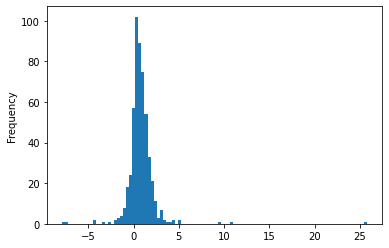

In [25]:
ftse_tidy_data.beta.plot.hist(bins = 100)